### Imports

In [151]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

import numpy as np
from plotters import Plotter
from neuropy.core.epoch import Epoch
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy import plotting
import replay_utils
import subjects

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Proportion of continuous trajectory
- Calculates proportion of PBEs that satisfy certain criteria have continous trajectory
- used for sd_paper Fig 4

In [136]:
from replay_utils import get_distance

sessions = subjects.pf_sess()
jump_thresh = 20
assert jump_thresh in [20, 40]
save_append = "" if jump_thresh == 40 else f"_jumpthresh{jump_thresh}"

cont_df = []
for s, sess in enumerate(sessions):
    replay_filt = sess.replay_filtered.to_dataframe() if jump_thresh == 40 else getattr(sess, f"replay_filtered{jump_thresh}jd").to_dataframe()
    # replay_filt.drop("posterior", axis=1, inplace=True)
    posteriors = replay_filt["posterior"].to_list()
    dist = np.array([np.abs(get_distance(_)) for _ in posteriors]) * 2
    # indx_bool = dist > 40  # & (replay_filt.max_length_perc_shuffle>=95)
    # replay_filt = replay_filt[indx_bool]

    all_pbe_df = sess.pbe_filters.to_dataframe()
    good_pbe = (all_pbe_df.is_rpl & all_pbe_df.is_5units & all_pbe_df.is_rest).values
    all_pbe_df = all_pbe_df[good_pbe]
    all_starts = all_pbe_df.start.values

    epochs = sess.get_zt_epochs()
    all_starts_labels = epochs.contains(all_starts)[2]

    labels1, freq1 = np.unique(all_starts_labels, return_counts=True)
    labels2, freq2 = np.unique(replay_filt.label.values, return_counts=True)

    df = pd.DataFrame(
        dict(zt=labels1, prop=freq2 / freq1, session=s, name=sess.name, grp=sess.tag)
    )
    df = df.iloc[[4, 3, 0, 1, 2]]
    # df.loc[:,'prop'] /= df[df['zt']=='PRE'].prop.values[0]

    cont_df.append(df)

cont_df = pd.concat(cont_df, ignore_index=True)
subjects.GroupData().save(cont_df, f"replay_continuous_events{save_append}")

#Sessions = 13
replay_continuous_events_jumpthresh20 saved


In [ ]:
from subjects import stat_kw
from statannotations.Annotator import Annotator
from plotters import violinplot

fig = plotting.Fig(grid=(5, 4))

ax = fig.subplot(fig.gs[0])

plot_kw = dict(data=cont_df, x="zt", y="prop", hue="grp", dodge=True, ax=ax)
sns.stripplot(
    **plot_kw, palette=subjects.colors_sd(1), edgecolor="w", linewidth=0.3, size=3
)
ax.legend([], frameon=False)
# Across groups
orders = cont_df.zt.unique()
pairs = [((_, "NSD"), (_, "SD")) for _ in orders[1:]] + [
    (("0-2.5", "NSD"), ("5-7.5", "SD"))
]
annotator = Annotator(pairs=pairs, **plot_kw, order=orders)
annotator.configure(test="Kruskal", **stat_kw, color="#4AB33E")
annotator.apply_and_annotate()
annotator.reset_configuration()

# Within groups
for i, g in enumerate(["NSD", "SD"]):
    pairs2 = [((orders[_], g), (orders[_ + 1], g)) for _ in range(4)] + [
        (("PRE", g), ("0-2.5", g))
    ]
    annotator = Annotator(pairs=pairs2, **plot_kw, order=orders)
    annotator.configure(test="Wilcoxon", **stat_kw, color=subjects.colors_sd(1)[i])
    annotator.apply_and_annotate()
    annotator.reset_configuration()


# ax= fig.subplot(fig.gs[1])

# df = cont_df[cont_df.is_cont].reset_index(drop=True)
# violinplot(data=df,x='zt',y='perc_shuffle',ax=ax)
# ax.set_ylim([-10,60])
# ax.set_yticks([0,10,20,30,40,50])

# fig.savefig(subjects.figpath_sd/'continuous_events')

### See sd_replay_viz.ipynb for CDFs of mean jump distance

#### Continuous replay trajectories by brainstate
See sd_replay_bootstrap.ipynb for replay trajectory proportion by brainstate - better code there. Below is an unfinished hack that could be used as a sanity check if necessary.

In [128]:
# from replay_utils import get_distance

# sessions = subjects.pf_sess()

# cont_df = []
# for s, sess in enumerate(sessions):
#     replay_filt = sess.replay_filtered.to_dataframe()
#     # replay_filt.drop("posterior", axis=1, inplace=True)
#     posteriors = replay_filt["posterior"].to_list()
#     dist = np.array([np.abs(get_distance(_)) for _ in posteriors]) * 2
#     # indx_bool = dist > 40  # & (replay_filt.max_length_perc_shuffle>=95)
#     # replay_filt = replay_filt[indx_bool]

#     all_pbe_df = sess.pbe_filters.to_dataframe()
#     good_pbe = (all_pbe_df.is_rpl & all_pbe_df.is_5units & all_pbe_df.is_rest).values
#     all_pbe_df = all_pbe_df[good_pbe]
#     all_starts = all_pbe_df.start.values

#     epochs = sess.get_zt_epochs()
#     all_starts_labels = epochs.contains(all_starts)[2]

#     # Add in brainstate
#     bs_df = sess.brainstates.to_dataframe()
#     nrem_epochs = Epoch(bs_df[bs_df.label == "NREM"])
#     is_nrem, _, _ = nrem_epochs.contains(good_pbe_df.start)
#     wake_epochs = Epoch(bs_df.loc[(bs_df.label == "QW") | (bs_df.label == "AW"), :])
#     is_wake, _, _ = wake_epochs.contains(good_pbe_df.start)

#     zt_epochs = sess.get_zt_epochs()

#     for e in zt_epochs.itertuples():
#         indx = (good_pbe_df.start >= e.start) & (good_pbe_df.stop <= e.stop)
#         e_df = pd.DataFrame(
#             dict(is_cont=is_cont[indx], zt=e.label, session=s, grp=sess.tag, brainstate="")
#         )
#         e_df.loc[is_nrem[indx], "brainstate"] = "NREM"
#         e_df.loc[is_wake[indx], "brainstate"] = "WAKE"


#         labels1, freq1 = np.unique(all_starts_labels, return_counts=True)  # get tally of all events by epoch
#         labels2, freq2 = np.unique(replay_filt.label.values, return_counts=True)  # get tally of continuous events by epoch

#     df = pd.DataFrame(
#         dict(zt=labels1, prop=freq2 / freq1, session=s, name=sess.name, grp=sess.tag, brainstate=)
#     )  # divide #continous events by total # events to get proportion
#     df = df.iloc[[4, 3, 0, 1, 2]]
#     # df.loc[:,'prop'] /= df[df['zt']=='PRE'].prop.values[0]

#     cont_df.append(df)

# cont_df = pd.concat(cont_df, ignore_index=True)
# subjects.GroupData().save(cont_df, "replay_continuous_events_brainstate_check")

#Sessions = 13
replay_continuous_events_brainstate saved


### (1h block) Proportion cont. traj.
- Included features: peak frequency, ripple power, and sharp wave amplitude

In [48]:
from replay_utils import get_distance

sessions = subjects.pf_sess()

cont_df = []
for s, sess in enumerate(sessions):
    replay_filt = sess.replay_filtered1h.to_dataframe()
    # replay_filt.drop("posterior", axis=1, inplace=True)
    posteriors = replay_filt["posterior"].to_list()
    dist = np.array([np.abs(get_distance(_)) for _ in posteriors]) * 2
    # indx_bool = dist > 40  # & (replay_filt.max_length_perc_shuffle>=95)
    # replay_filt = replay_filt[indx_bool]

    all_pbe_df = sess.pbe_filters.to_dataframe()
    good_pbe = (all_pbe_df.is_rpl & all_pbe_df.is_5units & all_pbe_df.is_rest).values
    all_pbe_df = all_pbe_df[good_pbe]
    all_starts = all_pbe_df.start.values

    epochs = sess.get_zt_1h()
    all_starts_labels = epochs.contains(all_starts)[2]

    labels1, freq1 = np.unique(all_starts_labels, return_counts=True)
    labels2, freq2 = np.unique(replay_filt.label.values, return_counts=True)

    df = pd.DataFrame(
        dict(zt=labels1, prop=freq2 / freq1, session=s, name=sess.name, grp=sess.tag)
    )
    # df = df.iloc[[4, 3, 0, 1, 2]]
    df = df.iloc[[7, 6, 0, 1, 2, 3, 4, 5]]
    # df.loc[:,'prop'] /= df[df['zt']=='PRE'].prop.values[0]

    cont_df.append(df)

cont_df = pd.concat(cont_df, ignore_index=True)
subjects.GroupData().save(cont_df, "replay_continuous_events_1h_blocks")

#Sessions = 13
replay_continuous_events_1h_blocks saved


In [41]:
# NRK sanity check for 1h vs full replay scores - should match up nicely with hours 1-2 only in 0-2.5, etc.
from copy import deepcopy
epochs = sess.get_zt_epochs()
epoch_df = deepcopy(replay_filt)
epochs_bool, _, starts_epochs_labels = epochs.contains(epoch_df.start.values)

epoch_df = epoch_df[epochs_bool].reset_index(drop=True)
epoch_df["label2"] = starts_epochs_labels

for label_check in epoch_df.label.unique():
    blocks_check = epoch_df[epoch_df.label == label_check].label2.unique()
    print(f"{label_check} contains the following 1hr blocks: {blocks_check}")

PRE contains the following 1hr blocks: ['PRE']
MAZE contains the following 1hr blocks: ['MAZE']
0-1 contains the following 1hr blocks: ['0-2.5']
1-2 contains the following 1hr blocks: ['0-2.5']
2-3 contains the following 1hr blocks: ['0-2.5' '2.5-5']
3-4 contains the following 1hr blocks: ['2.5-5']
4-5 contains the following 1hr blocks: ['2.5-5']
5-6 contains the following 1hr blocks: ['5-7.5']


In [39]:
# vice versa
epoch_df = sess.replay_filtered.to_dataframe()
epochs_bool, _, starts_epochs_labels = epochs.contains(epoch_df.start.values)

epoch_df = epoch_df[epochs_bool].reset_index(drop=True)
epoch_df["label2"] = starts_epochs_labels

for label_check in epoch_df.label.unique():
    blocks_check = epoch_df[epoch_df.label == label_check].label2.unique()
    print(f"{label_check} contains the following 1hr blocks: {blocks_check}")

PRE contains the following 1hr blocks: ['PRE']
MAZE contains the following 1hr blocks: ['MAZE']
0-2.5 contains the following 1hr blocks: ['0-1' '1-2' '2-3']
2.5-5 contains the following 1hr blocks: ['2-3' '3-4' '4-5']
5-7.5 contains the following 1hr blocks: ['5-6']


### Are awake replay proportion correlated with sleep replay ?

In [ ]:
fig = subjects.SdFig().fig_supp()
prop_df = subjects.GroupData().replay_continuous_events

for g, grp in enumerate(["NSD", "SD"]):
    for i, zt in enumerate(["0-2.5", "2.5-5", "5-7.5"]):
        x = prop_df[(prop_df.grp == grp) & (prop_df.zt == "MAZE")].prop.values
        y = prop_df[(prop_df.grp == grp) & (prop_df.zt == zt)].prop.values

        linfit = stats.linregress(x, y)
        r, m, c, pval = linfit.rvalue, linfit.slope, linfit.intercept, linfit.pvalue

        col = subjects.colors_sd(1)[g]

        ax = fig.subplot(fig.gs[2 * g, i])
        ax.scatter(x, y, s=2, color=col)
        ax.plot(x, m * x + c, color="gray", lw=0.5, alpha=0.5)
        ax.set_title(f"r={np.round(r,2)}, p={np.round(pval,2)}")

fig.savefig(subjects.figpath_sd / "awake_vs_sleep_replay_prop_correlation", format="svg")

### Are awake replay proportion correlated with EV in POST blocks

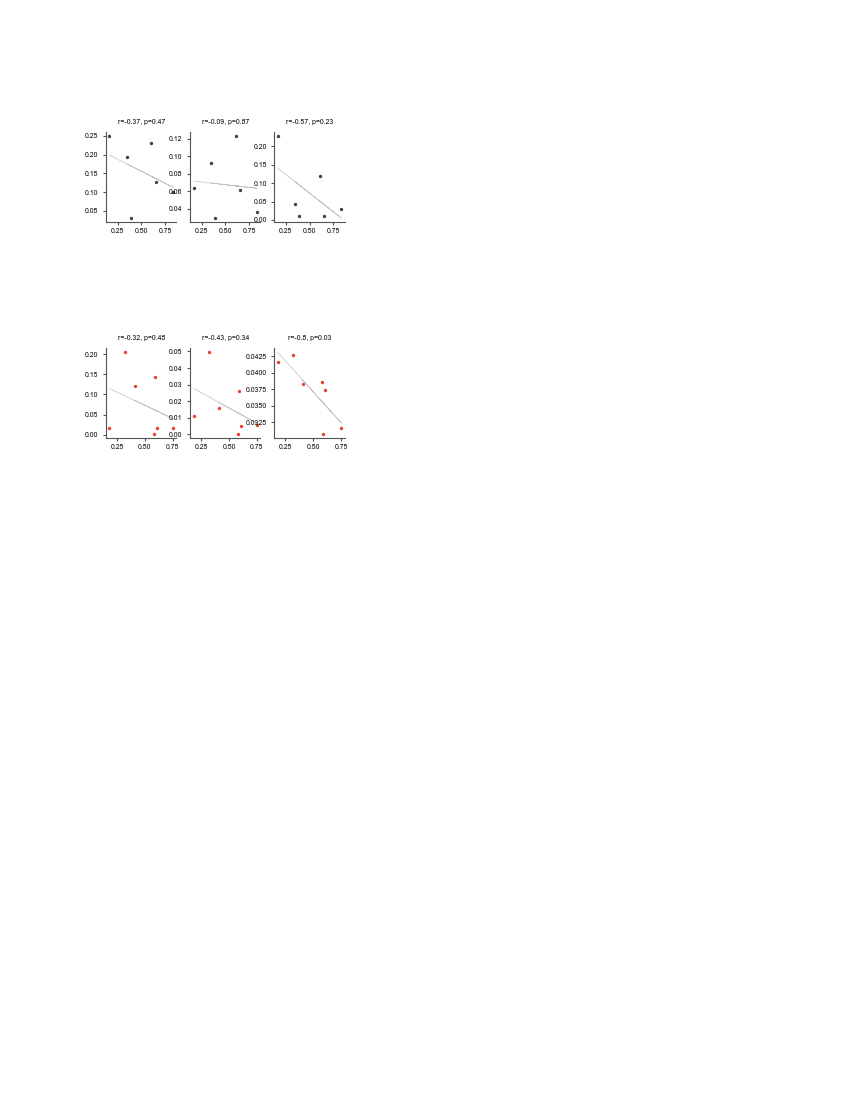

In [15]:
fig = subjects.SdFig().fig_supp()
prop_df = subjects.GroupData().replay_continuous_events
ev_df = subjects.GroupData().ev_in_chunks

for g, grp in enumerate(["NSD", "SD"]):
    for i, zt in enumerate(["0-2.5", "2.5-5", "5-7.5"]):
        x = prop_df[(prop_df.grp == grp) & (prop_df.zt == "MAZE")].prop.values
        # y = prop_df[(prop_df.grp == grp) & (prop_df.zt == zt)].prop.values
        y = ev_df[(ev_df.grp == grp) & (ev_df.zt == zt)].ev.values

        linfit = stats.linregress(x, y)
        r, m, c, pval = linfit.rvalue, linfit.slope, linfit.intercept, linfit.pvalue

        col = subjects.colors_sd(1)[g]

        ax = fig.subplot(fig.gs[2 * g, i])
        ax.scatter(x, y, s=2, color=col)
        ax.plot(x, m * x + c, color="gray", lw=0.5, alpha=0.5)
        ax.set_title(f"r={np.round(r,2)}, p={np.round(pval,2)}")

fig.savefig(subjects.figpath_sd / "awake_replay_prop_vs_ev_correlation", format="svg")

### Trajectory length of continuous events NSD vs SD
- It is possible that the length of continuous trajectory is shorter than the total duration of the PBE, so this code compares maximum length of continuous trajectory within the PBE between NSD and SD.

In [ ]:
sessions = subjects.pf_sess()

cont_df = []
for s, sess in enumerate(sessions):
    replay_filt = sess.replay_filtered.to_dataframe()
    # replay_filt.drop("posterior", axis=1, inplace=True)
    posteriors = replay_filt["posterior"].to_list()

    zt_epochs = sess.get_zt_epochs(include_pre=True, include_maze=True)

    for e in zt_epochs.itertuples():
        e_replay_length = replay_filt[
            (replay_filt.start >= e.start) & (replay_filt.stop <= e.stop)
        ].max_length.values
        df = pd.DataFrame(
            {"zt": e.label, "replay_length": e_replay_length, "grp": sess.tag}
        )

        cont_df.append(df)

cont_df = pd.concat(cont_df, ignore_index=True)

In [ ]:
fig = plotting.Fig(3, 2)

ax = fig.subplot(fig.gs[0, 0])
sns.boxplot(
    data=cont_df, x="zt", y="replay_length", hue="grp", split=True, inner="quartile"
)

### Jump distance of continuous events NSD vs SD

In [ ]:
sessions = subjects.pf_sess()

cont_df = []
for s, sess in enumerate(sessions):
    replay_filt = sess.replay_filtered.to_dataframe()
    # replay_filt.drop("posterior", axis=1, inplace=True)
    posteriors = replay_filt["posterior"].to_list()

    zt_epochs = sess.get_zt_epochs(include_pre=True, include_maze=True)

    for e in zt_epochs.itertuples():
        e_jd = replay_filt[
            (replay_filt.start >= e.start) & (replay_filt.stop <= e.stop)
        ].jd.values
        df = pd.DataFrame({"zt": e.label, "jd": e_jd, "session": s, "grp": sess.tag})

        cont_df.append(df)

cont_df = pd.concat(cont_df, ignore_index=True)

In [ ]:
import plotters

fig = subjects.SdFig().fig_supp()

ax = fig.subplot(fig.gs[0, 0])
p1 = plotters.Plotter(data=cont_df, x="zt", y="jd", hue="grp", ax=ax)
p1.boxplot_sd2(palette=subjects.colors_sd())
# p1.stat_anot_sd(stat_within='t-test_welch',stat_across='t-test_welch',alpha_across=0.05,alpha_within=0.05)

fig.savefig(subjects.figpath_sd / "jump_dist", format="svg")

### Trajectory slope/velocity comparision between NSD and SD

In [ ]:
sessions = subjects.pf_sess()

cont_df = []
for s, sess in enumerate(sessions):
    replay_filt = sess.replay_filtered.to_dataframe()
    # replay_filt.drop("posterior", axis=1, inplace=True)
    posteriors = replay_filt["posterior"].to_list()

    zt_epochs = sess.get_zt_epochs(include_pre=True, include_maze=True)

    for e in zt_epochs.itertuples():
        e_replay_length = replay_filt[
            (replay_filt.start >= e.start) & (replay_filt.stop <= e.stop)
        ].vel.values
        df = pd.DataFrame(
            {"zt": e.label, "velocity": np.abs(e_replay_length), "grp": sess.tag}
        )

        cont_df.append(df)

cont_df = pd.concat(cont_df, ignore_index=True)
cont_df = cont_df[cont_df.velocity <= 1500]

In [ ]:
fig = plotting.Fig(5, 5)

ax = fig.subplot(fig.gs[0, 0])
p1 = Plotter(data=cont_df, x="zt", y="velocity", hue="grp", hue_order=["NSD", "SD"])
p1.violinplot_sd(palette=subjects.colors_sd())


fig.savefig(subjects.figpath_sd / "trajectory_replay_velocity")

### Distribution of total distance replayed in continuous trajectories
- restricting this to only continuous portion of posterior

In [ ]:
from neuropy.utils.mathutil import thresh_epochs
import scipy.signal as sg


def get_max_dist(arr):
    max_loc = np.argmax(arr, axis=0)
    dist = np.abs(np.diff(max_loc))
    dist_logical = np.where(dist < 40, 1, 0)
    pad_dist = np.pad(dist_logical, (1, 1), "constant", constant_values=(0, 0))
    # starts, stops = thresh_epochs(pad_dist, 1, 3)[:2]
    peaks_dict = sg.find_peaks(pad_dist, height=1, width=1, plateau_size=3)[1]
    starts = peaks_dict["left_edges"] - 1
    stops = peaks_dict["right_edges"] - 1
    lengths = peaks_dict["plateau_sizes"] + 1
    print(lengths)
    # arg_max_length = np.argmax(lengths)
    # max_dist = max_loc[starts[arg_max_length]] - max_loc[stops[arg_max_length]]
    cum_dx = 0
    for i in range(len(lengths)):
        cum_dx += np.sum(dist[starts[i] : stops[i] + 1])

    # return np.abs(max_dist)
    return cum_dx


# sessions = subjects.pf_sess()

# dist_df = []
# for s, sess in enumerate(sessions[:1]):

#     df = sess.replay_filtered.to_dataframe()
#     posteriors = df["posterior"].to_list()
#     max_dist = np.array([get_max_dist(_) for _ in posteriors])
#     max_dist = max_dist / posteriors[0].shape[0]

#     df = pd.DataFrame(
#         dict(
#             zt=df.label.values,
#             max_dist=max_dist,
#             jd=df.jd.values,
#             name=sess.name,
#             grp=sess.tag,
#         )
#     )
#     dist_df.append(df)

# dist_df = pd.concat(dist_df, ignore_index=True)

In [ ]:
_, ax = plt.subplots()

arr = posteriors[0]
get_max_dist(arr)
ax.pcolormesh(arr)
ax.plot(np.arange(arr.shape[1]) + 0.5, arr.argmax(axis=0), "w*")

In [ ]:
from plotters import violinplot

_, ax = plt.subplots()

violinplot(data=dist_df, x="zt", y="max_dist", hue="grp", stat_anot=True)

### PBE duration of continuous trajectory comparison

In [146]:
replay_epochs = getattr(sess, replay_filtered) if jump_thresh == 40 else getattr(sess, f"replay_filtered{jump_thresh}jd")
replay_filt = replay_epochs.to_dataframe()
replay_filt

,start,stop,wcorr,jd,radon,vel,intercept,wcorr_perc,jd_perc,posterior,max_length,max_length_perc_shuffle,label,duration
0,13.128,13.260,0.025642,0.100000,0.578587,-27.481413,327.259817,55.6,0.4,"[[0.009169151756117232, 0.0026687636165148142,...",5,96.9,PRE,0.132
1,55.599,55.812,0.251502,0.126687,0.340281,471.639734,234.401969,88.6,0.1,"[[0.004220689753400893, 0.006244121168089831, ...",5,94.6,PRE,0.213
2,67.567,67.741,0.244633,0.157543,0.417842,-49.224939,330.683258,88.6,2.5,"[[0.009518542642818895, 0.0007602369055836672,...",6,99.5,PRE,0.174
3,113.532,113.713,0.133646,0.050818,0.318720,24.694648,295.080986,80.2,0.0,"[[0.000961737887682426, 1.962693207451882e-06,...",9,99.9,PRE,0.181
4,164.288,164.418,-0.106725,0.141121,0.358680,128.946341,288.333818,30.7,2.5,"[[0.008346469620506537, 6.282400773813194e-06,...",5,97.6,PRE,0.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,37353.829,37354.122,-0.130324,0.105679,0.355923,-59.432174,269.650240,22.0,0.0,"[[0.003333018249468931, 7.044970213534015e-05,...",6,97.2,5-7.5,0.293
515,37391.344,37391.460,-0.062056,0.035047,0.375740,-140.266784,325.485775,34.6,0.0,"[[0.0014951243442392487, 2.638022824836868e-05...",5,98.9,5-7.5,0.116
516,37470.599,37470.691,0.213979,0.020249,0.425120,353.985659,283.276910,85.7,0.0,"[[0.006002282363322365, 2.8632017361429774e-06...",4,94.6,5-7.5,0.092
517,37547.517,37547.679,-0.289430,0.131509,0.342655,75.816770,312.676128,4.5,0.6,"[[0.004220689753400893, 3.1500066384906605e-05...",5,96.1,5-7.5,0.162


In [127]:
sessions = subjects.pf_sess()

sessions = subjects.pf_sess()
jump_thresh = 20
assert jump_thresh in [20, 40]
save_append = "" if jump_thresh == 40 else f"_jumpthresh{jump_thresh}"

cont_df = []
for s, sess in enumerate(sessions):
    replay_epochs = getattr(sess, "replay_filtered") if jump_thresh == 40 else getattr(sess, f"replay_filtered{jump_thresh}jd")
    replay_filt = replay_epochs.to_dataframe()
    # replay_filt.drop("posterior", axis=1, inplace=True)
    posteriors = replay_filt["posterior"].to_list()

    zt_epochs = sess.get_zt_epochs(include_pre=True, include_maze=True)

    for e in zt_epochs.itertuples():
        e_duration = replay_filt[
            (replay_filt.start >= e.start) & (replay_filt.stop <= e.stop)
        ].duration.values
        df = pd.DataFrame(
            {
                "pbe_duration": np.abs(e_duration),
                "zt": e.label,
                "session": s,
                "grp": sess.tag,
            }
        )

        cont_df.append(df)

cont_df = pd.concat(cont_df, ignore_index=True)

subjects.GroupData().save(cont_df, f"continuous_replay_PBE_duration{save_append}")

#Sessions = 13
#Sessions = 13
continuous_replay_PBE_duration_jumpthresh20 saved


In [153]:
# by brainstate
sessions = subjects.pf_sess()

sessions = subjects.pf_sess()
jump_thresh = 40
assert jump_thresh in [20, 40]
save_append = "" if jump_thresh == 40 else f"_jumpthresh{jump_thresh}"

cont_df = []
for s, sess in enumerate(sessions):
    replay_epochs = getattr(sess, "replay_filtered") if jump_thresh == 40 else getattr(sess, f"replay_filtered{jump_thresh}jd")
    replay_filt = replay_epochs.to_dataframe()
    # replay_filt.drop("posterior", axis=1, inplace=True)
    posteriors = replay_filt["posterior"].to_list()

    zt_epochs = sess.get_zt_epochs(include_pre=True, include_maze=True)

    # ID brainstate epochs for adding in in loop below
    bs_df = sess.brainstates.to_dataframe()
    nrem_epochs = Epoch(bs_df[bs_df.label == "NREM"])
    is_nrem, _, _ = nrem_epochs.contains(replay_filt.start)
    wake_epochs = Epoch(bs_df.loc[(bs_df.label == "QW") | (bs_df.label == "AW"), :])
    is_wake, _, _ = wake_epochs.contains(replay_filt.start)

    for e in zt_epochs.itertuples():
        indx = (replay_filt.start >= e.start) & (replay_filt.stop <= e.stop)
        e_duration = replay_filt[indx].duration.values
        df = pd.DataFrame(
            {
                "pbe_duration": np.abs(e_duration),
                "zt": e.label,
                "session": s,
                "grp": sess.tag,
            }
        )
        df.loc[is_nrem[indx], "brainstate"] = "NREM"
        df.loc[is_wake[indx], "brainstate"] = "WAKE"

        cont_df.append(df)


cont_df = pd.concat(cont_df, ignore_index=True)

subjects.GroupData().save(cont_df, f"continuous_replay_PBE_duration{save_append}_bs")

#Sessions = 13
#Sessions = 13


/home/nkinsky/Documents/GitHub/NeuroPy/neuropy/core/epoch.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epochs.loc[:, "label"] = epochs["label"].astype("str")
/home/nkinsky/Documents/GitHub/NeuroPy/neuropy/core/epoch.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epochs.loc[:, "label"] = epochs["label"].astype("str")
/home/nkinsky/Documents/GitHub/NeuroPy/neuropy/core/epoch.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

continuous_replay_PBE_duration_bs saved


/home/nkinsky/Documents/GitHub/NeuroPy/neuropy/core/epoch.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epochs.loc[:, "label"] = epochs["label"].astype("str")
/home/nkinsky/Documents/GitHub/NeuroPy/neuropy/core/epoch.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epochs.loc[:, "label"] = epochs["label"].astype("str")
/home/nkinsky/Documents/GitHub/NeuroPy/neuropy/core/epoch.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [49]:
sessions = subjects.pf_sess()

cont_df = []
for s, sess in enumerate(sessions):
    replay_filt = sess.replay_filtered.to_dataframe()
    # replay_filt.drop("posterior", axis=1, inplace=True)
    posteriors = replay_filt["posterior"].to_list()

    zt_epochs = sess.get_zt_1h(include_pre=True, include_maze=True)

    for e in zt_epochs.itertuples():
        e_duration = replay_filt[
            (replay_filt.start >= e.start) & (replay_filt.stop <= e.stop)
        ].duration.values
        df = pd.DataFrame(
            {
                "pbe_duration": np.abs(e_duration),
                "zt": e.label,
                "session": s,
                "grp": sess.tag,
            }
        )

        cont_df.append(df)

cont_df = pd.concat(cont_df, ignore_index=True)

subjects.GroupData().save(cont_df, "continuous_replay_PBE_duration_1h_blocks")

#Sessions = 13
continuous_replay_PBE_duration_1h_blocks saved


In [ ]:
fig = plotting.Fig(5, 5)

ax = fig.subplot(fig.gs[0, 0])
p1 = Plotter(data=cont_df, x="zt", y="pbe_duration", hue="grp", hue_order=["NSD", "SD"])
p1.violinplot_sd(palette=subjects.colors_sd())


fig.savefig(subjects.figpath_sd / "trajectory_replay_PBE_duration")

### Proportion of forward vs reverse replay

In [ ]:
sessions = subjects.pf_sess()

replay_bias_df = []
for s, sess in enumerate(sessions):
    zt_epochs = sess.get_zt_epochs()
    cont_replay_df = sess.replay_filtered.to_dataframe()
    # all_replay_df = sess.replay_pbe_mua.to_dataframe()

    # all_pbe_df = sess.pbe_filters.to_dataframe()
    # good_pbe = (all_pbe_df.is_rpl & all_pbe_df.is_5units & all_pbe_df.is_rest).values

    # good_pbe_df = all_pbe_df.loc[good_pbe, ["start", "stop"]].reset_index(drop=True)
    # is_cont = np.isin(good_pbe_df.start, cont_replay_df.start)

    for e in zt_epochs.itertuples():
        indx = (cont_replay_df.start >= e.start) & (cont_replay_df.stop <= e.stop)
        e_wcorr = cont_replay_df[indx]["wcorr"].values
        n_forward = np.sum(e_wcorr > 0)
        n_reverse = np.sum(e_wcorr < 0)
        bias = (n_forward - n_reverse) / (n_forward + n_reverse)
        e_df = pd.DataFrame(dict(replay_bias=[bias], zt=e.label, session=s, grp=sess.tag))

        replay_bias_df.append(e_df)

replay_bias_df = pd.concat(replay_bias_df, ignore_index=True)

subjects.GroupData().save(replay_bias_df, "continuous_replay_bias_blocks")

In [ ]:
_, ax = plt.subplots()

sns.stripplot(data=replay_bias_df, x="zt", y="replay_bias", hue="grp", dodge=True)